<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/notebooks/Image_Simulation_HST_UVIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><b> How to use PISTA for image simulation</b></h1>

# **Initialize**

Do not edit this section

In [1]:
#!pip install insist-pista --quiet
# For Development version. Uncomment and run the code below instead
!pip install git+https://github.com/Jack3690/INSIST --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 35.6 MB/s eta 0:00:00


In [2]:
import pista as pt

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import pandas as pd
import os

import astropy.units as u
from astropy.table import Table, vstack
from astropy.visualization import make_lupton_rgb
from astropy.io import fits
from astropy.wcs import WCS

from scipy.interpolate import interp2d
import seaborn as sb

In [3]:
data_path = pt.data_dir

# **Python Image Simulation and Testing Application (PISTA)**

PISTA package allows user to simulate resolved stellar population using source catalog and detector characteristics. This notebook contains few examples on how to use PISTA

## **Step 1**
Upload a dataframe with columns 'ra', 'dec', 'mag'.

In [44]:
# Example using FITS table
tab = Table.read(f'/content/F606W_GC_catalog.fits')  # FITS Table
df  = tab.to_pandas()             # PISTA requires pandas DataFrame
df

ext  chip       x       y  chi_fit  obj_SNR  obj_sharpness  \
0    0.0   1.0  125.63  127.55     5.74    326.3         -0.265   
1    0.0   1.0  127.97  126.77     7.14    175.7         -0.239   
2    0.0   1.0  124.64  125.41     7.45    177.2         -0.290   
3    0.0   1.0   67.35  110.53     2.61    104.0          0.386   
4    0.0   1.0  114.03  185.08     7.61     84.9          0.211   
..   ...   ...     ...     ...      ...      ...            ...   
319  0.0   1.0  105.96  208.82     0.85      6.6         -0.184   
320  0.0   1.0  142.25  106.20     1.04      5.3         -0.339   
321  0.0   1.0  122.78  216.48     1.03      5.8          0.161   
322  0.0   1.0   77.58  163.86     1.13      5.5          0.163   
323  0.0   1.0   85.75   61.70     1.03      4.9          0.176   

     obj_roundness  dir_maj_axis  obj_crowd  ...  mag_ubvri  mag_err   chi  \
0            0.084         125.0      0.388  ...     99.999    0.004  5.91   
1            0.095         110.0      0.787  ...     99.999    0.006  7.10   
2            0.169         100.0      0.728  ...     99.999    0.006  7.47   
3            0.239          85.0      0.037  ...     99.999    0.139  1.03   
4            0.399          80.0      0.011  ...     99.999    0.095  2.73   
..             ...           ...        ...  ...        ...      ...   ...   
319          0.421         175.0      0.239  ...     99.999    0.169  0.86   
320          0.412         120.0      0.839  ...     99.999    0.226  1.04   
321          0.733          70.0      0.070  ...     99.999    0.201  0.99   
322          1.253         165.0      0.027  ...     99.999    0.235  1.14   
323          0.484         125.0      0.040  ...     99.999    0.231  0.99   

       SNR  sharpness  roundness  crowd  flags          ra        dec  
0    307.5     -0.264      0.083  0.383    0.0  149.477810  68.816973  
1    175.0     -0.239      0.095  0.787    2.0  149.477739  68.816965  
2    175.3     -0.290      0.173  0.728    2.0  149.477840  68.816949  
3      7.8      0.386      0.240  0.041    0.0  149.479580  68.816780  
4     11.5      0.211      0.400  0.012    2.0  149.478180  68.817605  
..     ...        ...        ...    ...    ...         ...        ...  
319    6.4     -0.184      0.420  0.239    0.0  149.478432  68.817865  
320    4.8     -0.339      0.412  0.839    0.0  149.477298  68.816740  
321    5.4      0.165      0.641  0.071    2.0  149.477922  68.817951  
322    4.6      0.163      0.850  0.027    0.0  149.479284  68.817368  
323    4.7      0.176      0.478  0.040    2.0  149.479006  68.816244  

[324 rows x 26 columns]

In [ ]:
# Run these cells to upload files otherwise ignore
from google.colab import files

uploaded = files.upload()

In [ ]:
ls # Shows the files in the current working directory

sample_data/


## **Step 2**

Create a dictionary object with telescope parameters.


Dictionary structure

```
tel_params : dict,
 |                   {'aperture'       : float,  cm
 |                    'pixel_scale'    : float,  arcsecs/pixels
 |                    'psf_file'       : fits,npy
 |                    'response_funcs' : list, [filename.dat, n, max]
 |
 |                                             where
 |                                             n is number of times
 |                                             a given profile is repeated.
 |                                             For example if there are 5
 |                                             mirrors with sample coating
 |                                             profile, n = 5.
 |
 |                                             max is the upper limit of a
 |                                             response function. For example,
 |                                             if filter profiles are in
 |                                             percentage, max = 100.
 |
 |                    'coeffs'         : float, filter coefficients if not
 |                                            response_funcs
 |                    }
```

aperture : aperture of the primary mirror in cms <br>

pixel_scale : pixel scale of the detector in arcseconds/pixels<br>

sim_file    : path to the file containing point spread function data in the form of a 2D array. User can use both npy or FITS data. <br>

response_funcs : Dictionary containing paths to filter, dichroic, coating efficiency, quantum efficieny etc. profiles.<br>

Format for dictionary is [\<path>, \<multiplicity factor>, \<maximum value>]<br>


```
response_funcs = [
                   '..\path\coating.dat,1,100',
                   '..\path\dichroic.dat,2,1'
                 ]

```

coeffs : response coefficient. If user doesn't wanna use filter and response function profiles. They can directly enter the total multiplicate factor that needs to go into the effective area. Such that coeff = c1*c2*c3*..

Where c1,c2,c3 are response function coefficients

In the example below we will use INSIST parameters which is included in the PISTA package data

In [5]:
hdul = fits.open('/content/PSFSTD_WFC3UV_F606W.fits',ignore_missing_end=True)

???????????????????????????????????????????????????????????????????????????????? [astropy.io.fits.card]
????????????????????????????????????????????????????????????????????????????????


In [6]:
psf = np.median(hdul[0].data[:7], axis=0)

In [7]:
y,x = np.mgrid[-50:51,-50:51]/50

y_new = np.arange(-12,13,1)/12.625
x_new = np.arange(-12,13,1)/12.625

In [ ]:
interp = interp2d(x,y,psf)
psf_new = interp(x_new,y_new)

In [9]:
np.save('/content/psf.npy', psf_new)

In [45]:
tel_params ={
            'aperture'       : 240,
            'pixel_scale'    : 0.0396,
            'psf_file'       : f'/content/psf.npy',
            'response_funcs' :  [ f'HST_WFC3_UVIS1.F606W.dat,1,1'
                                ],
            'coeffs'         : 0.923635,
            }

## **Step 3**

Initialize PISTA Analyzer object

n_x : Number of pixels along RA direction. <br>
n_y : Number of pixels along Dec direction <br>
exp_time : Exposure time in seconds

In [46]:
df['mag'] = df['mag_vega_F606W']

In [147]:
df['r'] = np.sqrt((df['x']-127)**2 + (df['y']-126)**2 )

In [148]:
df_new = df[df['r']>4].copy()

In [149]:
sim = pt.Imager(df = df_new,tel_params = tel_params, n_x = 300, n_y = 300,
                   exp_time = 677*np.sqrt(6))

PSF data has negative values!
 Modulus of PSF used instead


In [150]:
2.5*np.log10(sim.zero_flux) - 2.5*np.log10(sim.exp_time)

26.004005226659558

(<Figure size 1200x1000 with 2 Axes>,
 <Axes: title={'center': 'Requested Center :  RA : 149.478 degrees, Dec : 68.817 degrees | 314 sources\n          Fov(RA) : 0.0033 (deg) | Fov(Dec) : 0.0033 (deg)'}, xlabel='RA (Degrees)', ylabel='Dec (Degrees)'>)

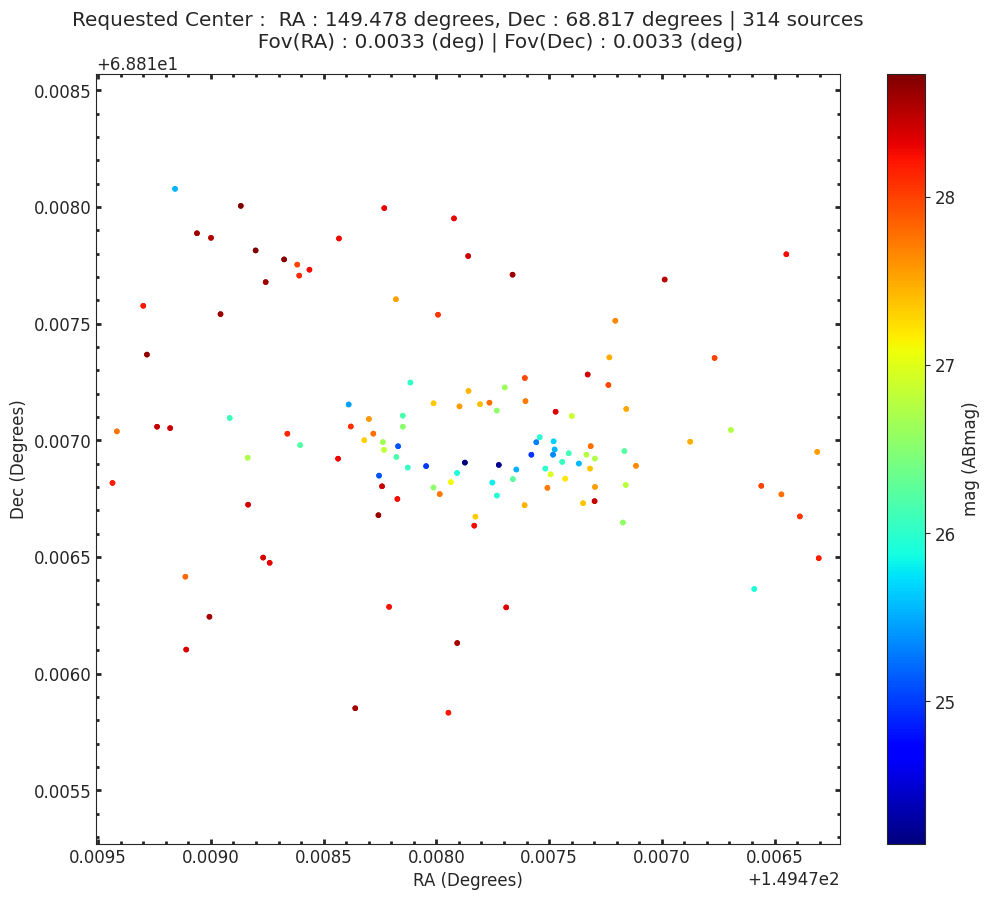

In [151]:
sim.show_field(figsize=(12, 10)) # Displays the RA-Dec scatter of sources withing the Field of View

## **Step 4**

Create dictionary object with Detector parameters



```
det_params: dict, optional
        Dictionary contianing detector parameters. The default is None.
                   {     'shot_noise' :  str,
                         'M_sky'      :  float,    Sky magnitude
                         'qe_response':  list,     QE Response Function
                         'qe_mean'    :  float
                         'qe_sigma'   :  float,    Pixel to pixel fluctuation
                         'bias'       :  float,    electrons
                         'G1'         :  float,    ADU/e
                         'bit_res'    :  int,
                         'RN'         :  float,     elec/pix
                         'PRNU_frac'  :  float,     PRNU sigma
                         'T'          :  float,     K
                         'DFM'        :  float,     pA
                         'pixel_area' :  float,     cm2
                         'DCNU'       :  float,     DNCU sigma
                         'DNFP        :  float,     Fixed patter value
                         'NF'         :  float,     electrons
                         'FWC'        :  float,     electrons
                         'C_ray_r'    :  float      hits/second
                     }
```


shot_noise : Distribuition to be used for shot_noise, 'Gaussian' or 'Possonian' <br>

M_sky : sky magnitude in $ABmag/arcsecond^2$. If filter profiles are not used.<br>

qe_sigma : standard deviation of quantum efficiency across pixel on the detector. <br>

bias : detector offset in electrons<br>

G1   : Detector gain<br>

bit_res : bit resolution of the detector<br>

RN      : Read noise of the detector in electrons<br>

PRNU_frac: Photon Responce non uniformity fraction<br>

T        : Temperature of the detector in Kelvin <br>

DFM      : Dark Current figure of meric in unit $pA/cm^2$ <br>

pixel_area : area of pixel in cm^2 <br>

DCNU   : Dark Current Non Uniformity <br>

DNFP   : Dark Current Fixed Pattern <br>

NF   : Noise floor in electrons<br>

C_ray_r' cosmic ray hits rate $hits/second/arcsecond^2$

In [142]:
det_params = {    'shot_noise' :  'Gaussian',
                  'G1'         :  1/1.57,
                  'FWC'        :  63000,
                  'bias'       :  10,
                  'bit_res'    :  16,
                  'RN'         :  3.1,
                  'PRNU_frac'  :  1/100,
                  'qe_response': [f'{data_path}/INSIST/UV/QE.dat,1,100'],
                  'DFM'        :  810*1.424e-2,
                  'pixel_area' :  2.25e-06,
                  'T'          :  190,
                  'DCNU'       :  10/100,
             }

## **Step 5**

Run simulation by calling the sim object with required arguments

In [152]:
sim(det_params = det_params, photometry = 'Aper', detect_source = True)

  0%|          | 0/314 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pista/analysis.py:213: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux'].value) + ZP


In [153]:
sim.ZP - 2.5*np.log10(sim.exp_time)

26.004005226659558

In [154]:
digital = sim.digital - sim.dark_frame - sim.bias_frame
# Flat field correction
digital = digital.astype(float)
digital /= sim.flat_frame

digital = digital/sim.exp_time

In [155]:
digital[:20,:20].mean(), digital[:20,:20].std()

(0.00040794754362659294, 0.0006108994498343603)

(<Figure size 1500x1000 with 2 Axes>,
 <WCSAxes: title={'center': 'Digital \nRequested center :  RA : 149.478 degrees, Dec : 68.817 degrees'}>)

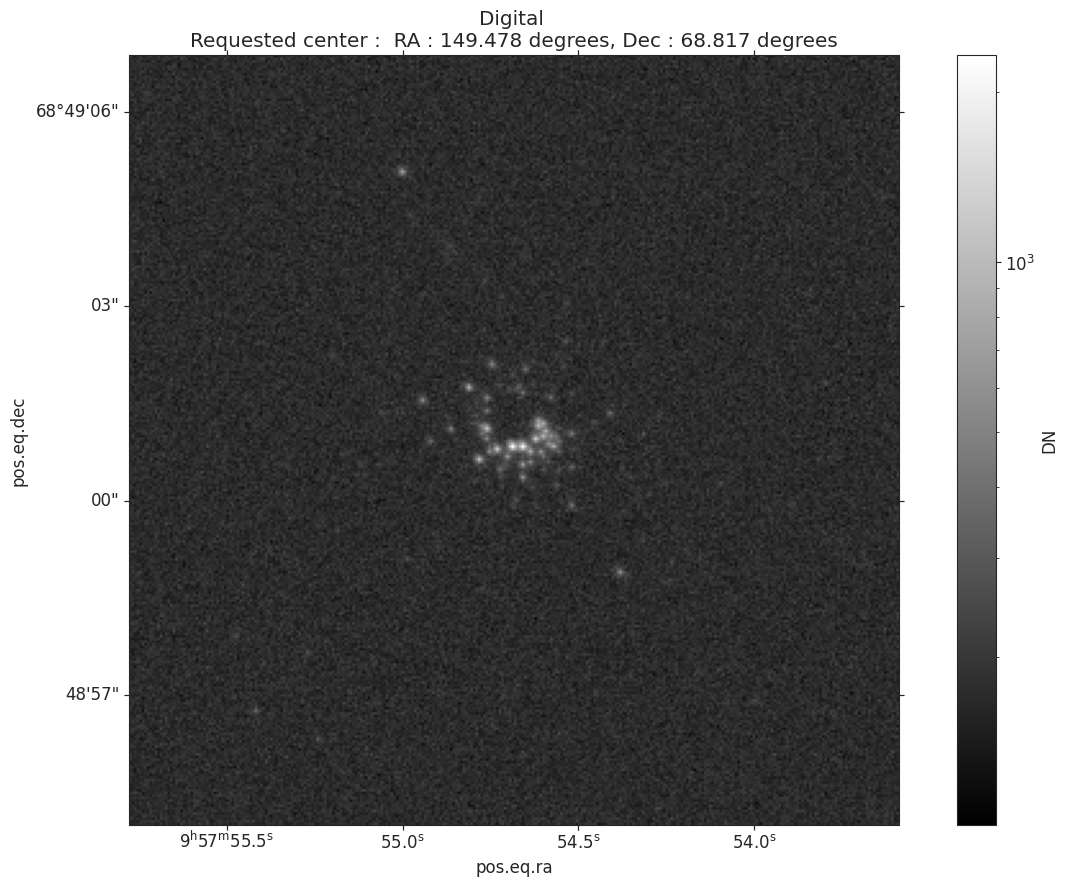

In [156]:
sim.show_image(cmap='gray') # Displays the final simulated digital image

In [24]:
sim.phot_table # Displays table with aperture photometry of the image

<QTable length=318>
  id       xcenter       ...      mag_out             mag_err       
             pix         ...                                        
int64      float64       ...      float64             float64       
----- ------------------ ... ------------------ --------------------
    1  92.39725443050527 ...  27.85958210080203  0.44088572012450283
    2 138.41836054315738 ...  27.21372680084471  0.24484200198053616
    3   79.0002036644732 ...  27.16305827298526  0.23289107711776014
    4 197.28218769373476 ...  27.70239513726911  0.38096994950810514
    5 173.39937099784387 ...                nan   -2.112438341960297
    6  191.6604581343492 ...  27.72559542236388  0.39021394868337206
    7  155.2218630775441 ...  22.92321752904363 0.008495749734424343
    8   211.264708465055 ... 27.320812905714075   0.2695755615620111
    9  148.9506821066216 ... 27.770708326135523   0.4042601937603467
  ...                ... ...                ...                  ...
  309 129.99015806641964 ...                nan  -1.8789816024251502
  310 120.02470795451414 ... 27.469039426255296   0.3077068718950043
  311 161.69069676547196 ... 26.550133695340904  0.13542200515971314
  312 112.86725623054991 ...  29.01789486488913   1.2700813834459515
  313 119.44707240164517 ... 28.027015658574168   0.5121892245171384
  314 130.12791162978343 ...  28.45929624157727   0.7616044366270683
  315 167.37148945626333 ...  26.93827960189492  0.19188985155841418
  316 146.88578218137772 ...  27.77430903325414   0.4073365397868488
  317 102.14517512237063 ... 27.679453577163176   0.3706905127343984
  318 111.25152291227744 ... 28.243882449480008   0.6235435106674938

**Comparing input magnitude vs output magnitude**

Text(0, 0.5, 'Output - Input (Mag)')

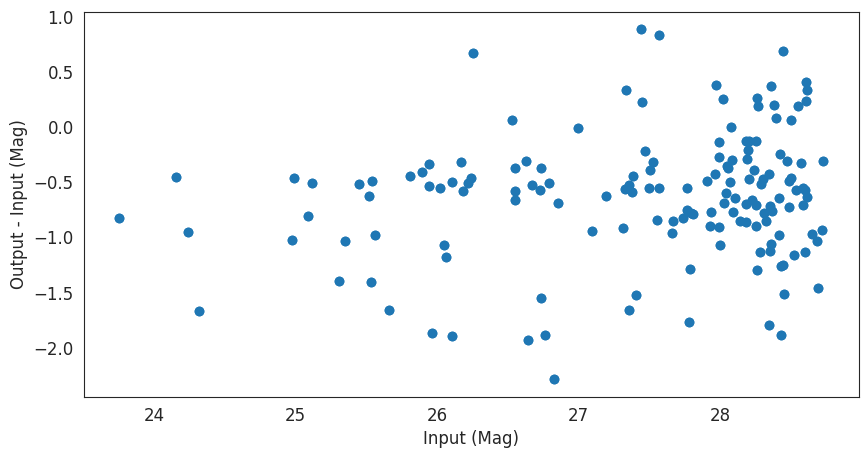

In [25]:
x = sim.phot_table['mag_in']
y = sim.phot_table['mag_out']-sim.phot_table['mag_in']

plt.figure(figsize = (10,5))
plt.scatter(x, y)
plt.xlabel('Input (Mag)')
plt.ylabel('Output - Input (Mag)')

Text(0, 0.5, 'Output (mag)')

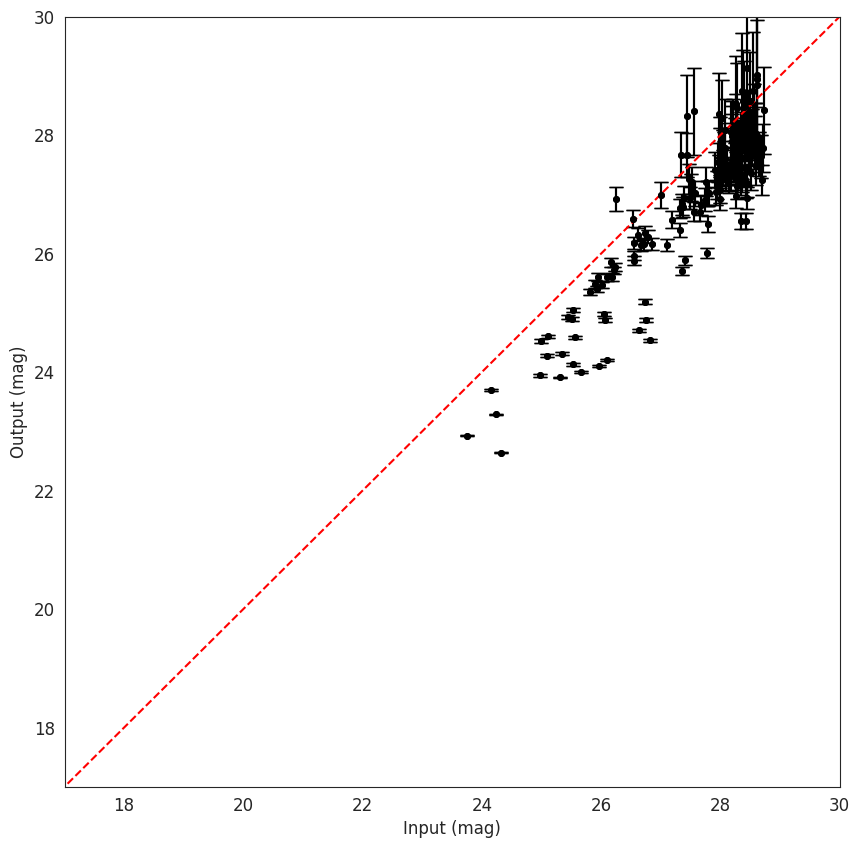

In [26]:
x = sim.phot_table['mag_in']
y = sim.phot_table['mag_out']
y_err = abs(sim.phot_table['mag_err'])
plt.errorbar(x,y,yerr= y_err,fmt='o', color = 'black', markersize=4, capsize=5)
plt.plot([16,30],[16,30],'--', color = 'red')

plt.xlim(17,30)
plt.ylim(17,30)

plt.xlabel('Input (mag)')
plt.ylabel('Output (mag)')

**Downloading output image as FITS**

In [157]:
sim.writeto('/content/sim.fits')

In [ ]:
from google.colab import files

files.download('sample_sim.fits')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [158]:
hdul = fits.open('/content/sim.fits')

In [159]:
data = hdul[0].data
header = hdul[0].header

In [160]:
header['BUNIT'] = 'ELECTRON/S'
header['ZP'] = sim.ZP - 2.5*np.log10(sim.exp_time)
header['FILTER'] = 'F606W'
data = digital.astype(np.float32)

hdu1 = fits.PrimaryHDU()
hdu2 = fits.ImageHDU(data, header)
hdul = fits.HDUList([hdu1, hdu2])
hdul.writeto('/content/sim_M81_GC_cen_cropped.fits', overwrite=True)

## **Explorative Analysis using the Simulator**

In this section we use PISTA to generate few standard plots and perform some analysis

### **Photon Response Curves**

/usr/local/lib/python3.10/dist-packages/pista/analysis.py:178: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
<ipython-input-29-d491eadc1e5c>:43: RuntimeWarning: invalid value encountered in sqrt
  y = x/np.sqrt(sim.source_photoelec).ravel()
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:178: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
<ipython-input-29-d491eadc1e5c>:62: RuntimeWarning: invalid value encountered in sqrt
  y = x/np.sqrt(sim.source_photoelec).ravel()
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:178: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
<ipython-input-29-d491eadc1e5c>:81: RuntimeWarning: invalid value encountered in sqrt
  y = x/np.sqrt(sim.photoelec_array + sim.PRNU_array**2).ravel()
/usr/local/lib/python3.10/dist-packages/pista/an

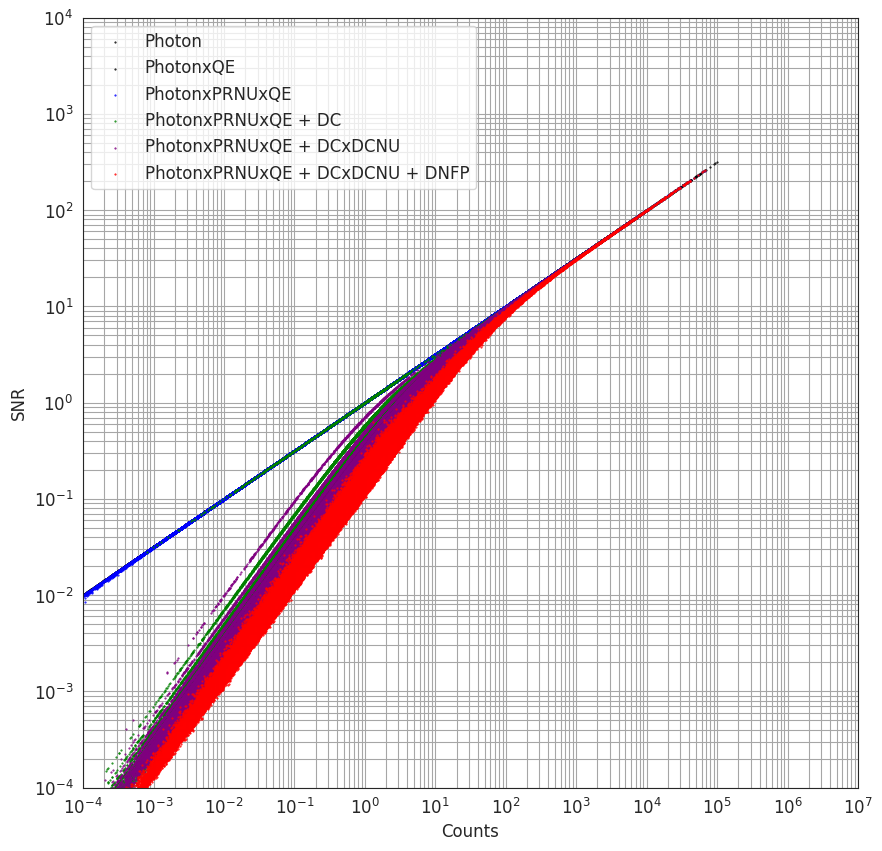

In [ ]:
fig, ax = plt.subplots(1,1, figsize= (10,10))

tel_params = {'sim_file': f'{data_path}/PSF/INSIST/on_axis_hcipy.npy',
              'pixel_scale'   : 0.1,
              'response_funcs': [f'{data_path}/INSIST/UV/Coating.dat,5,100',
                                 f'{data_path}/INSIST/UV/Dichroic.dat,2,100',
                                 f'{data_path}/INSIST/UV/Filter.dat,1,100',
                                 ]}


det_params = {'shot_noise': 'Gaussian',
                      'M_sky'      :  27,
                      'qe_response': [f'{data_path}/INSIST/UV/QE.dat,1,100'],
                      'qe_sigma'   :  0.01,       # Pixel to pixel fluctuation
                      'bias'       :  35,         # electrons
                      'G1'         :  1,
                      'bit_res'    :  14,
                      'RN'         :  5,          # elec/pix
                      'PRNU_frac'  :  0.25/100,   # PRNU sigma
                      'T'          :  218,        # K
                      'DFM'        :  1.424e-2,   # 14.24 pA
                      'pixel_area' :  1e-6,       #
                      'DCNU'       :  0.1/100,    #
                      'DNFP'       :  10.,
                      'NF'         :  0,          # electrons
                      'FWC'        :  1.4e5,      # electrons
                      'C_ray_r'    :  2/50        # hits/second
                   }

sim =  pt.Imager(df = df, tel_params = tel_params, exp_time = 600,
             n_x  = 800, n_y = 800)

sim.QE   = False
sim.sky  = False
sim.PRNU = False
sim.DC   = False

sim(det_params = det_params)


# Source Photons
x = (sim.source_photoelec).ravel()
y = x/np.sqrt(sim.source_photoelec).ravel()
x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)

ax.scatter(x,y,s=1,marker = '.', color ='black')

sim = pt.Imager(df = df, tel_params = tel_params, exp_time = 600,
                n_x  = 800, n_y = 800)


sim.QE   = True
sim.sky  = False
sim.PRNU = False
sim.DC   = False

sim(det_params = det_params)

# Source Photoelectrons
x = (sim.source_photoelec).ravel()
y = x/np.sqrt(sim.source_photoelec).ravel()
x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)

ax.scatter(x,y,s=1,marker = '.', color ='black')

sim = pt.Imager(df=df, tel_params=tel_params, exp_time=600,
                n_x=800, n_y=800)


sim.QE   = True
sim.sky  = False
sim.PRNU = True
sim.DC   = False

sim(det_params = det_params)

# PRNU
x = (sim.photoelec_array-sim.DC_array).ravel()
y = x/np.sqrt(sim.photoelec_array + sim.PRNU_array**2).ravel()
x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)

ax.scatter(x,y,s=1,marker = '.', color ='blue')

sim = pt.Imager(df=df, tel_params=tel_params, exp_time=600,
                n_x=800, n_y=800)

sim.QE   = True
sim.sky  = False
sim.PRNU = True
sim.DC   = True
sim.DCNU = False
sim.DNFP = False

sim(det_params = det_params)

# With DC

x = (sim.photoelec_array-sim.DC_array).ravel()
y = x/np.sqrt(sim.photoelec_array + sim.PRNU_array**2 + sim.DC_array).ravel()

x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)
ax.scatter(x,y,s=1,marker = '.', color ='green')

sim = pt.Imager(df=df, tel_params=tel_params, exp_time=600,
                n_x=800, n_y=800)

sim.QE   = True
sim.sky  = False
sim.PRNU = True
sim.DC   = True
sim.DCNU = True
sim.DNFP = False
sim(det_params = det_params)

# With DCNU
x = (sim.photoelec_array-sim.DC_array).ravel()
y = x/np.sqrt(sim.photoelec_array + sim.PRNU_array**2 + sim.DC_array + sim.DCNU_array**2).ravel()

x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)
ax.scatter(x,y,s=1,marker = '.', color ='purple')

sim = pt.Imager(df=df, tel_params=tel_params, exp_time=600,
                n_x=800, n_y=800)

sim.QE   = True
sim.sky  = False
sim.PRNU = True
sim.DC   = True
sim.DCNU = True
sim.DNFP = True
sim(det_params = det_params)

# With DNFP
x = (sim.photoelec_array-sim.DC_array).ravel()
y = x/np.sqrt(sim.photoelec_array + sim.PRNU_array**2 + sim.DC_array + sim.DCNU_array**2 + sim.DNFP_array).ravel()

x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)
ax.scatter(x,y,s=1,marker = '.', color ='red')


ax.set_xlabel('Counts')
ax.set_ylabel('SNR')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-4,1e7)
ax.set_ylim(1e-4,1e4)
ax.xaxis.set_major_locator(LogLocator(numticks=15))
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10)))

plt.grid(True, which="both",axis = 'both', ls="-", color='0.65')
plt.legend(['Photon','PhotonxQE', 'PhotonxPRNUxQE', 'PhotonxPRNUxQE + DC','PhotonxPRNUxQE + DCxDCNU','PhotonxPRNUxQE + DCxDCNU + DNFP']);

Text(0.5, 0, 'Y')

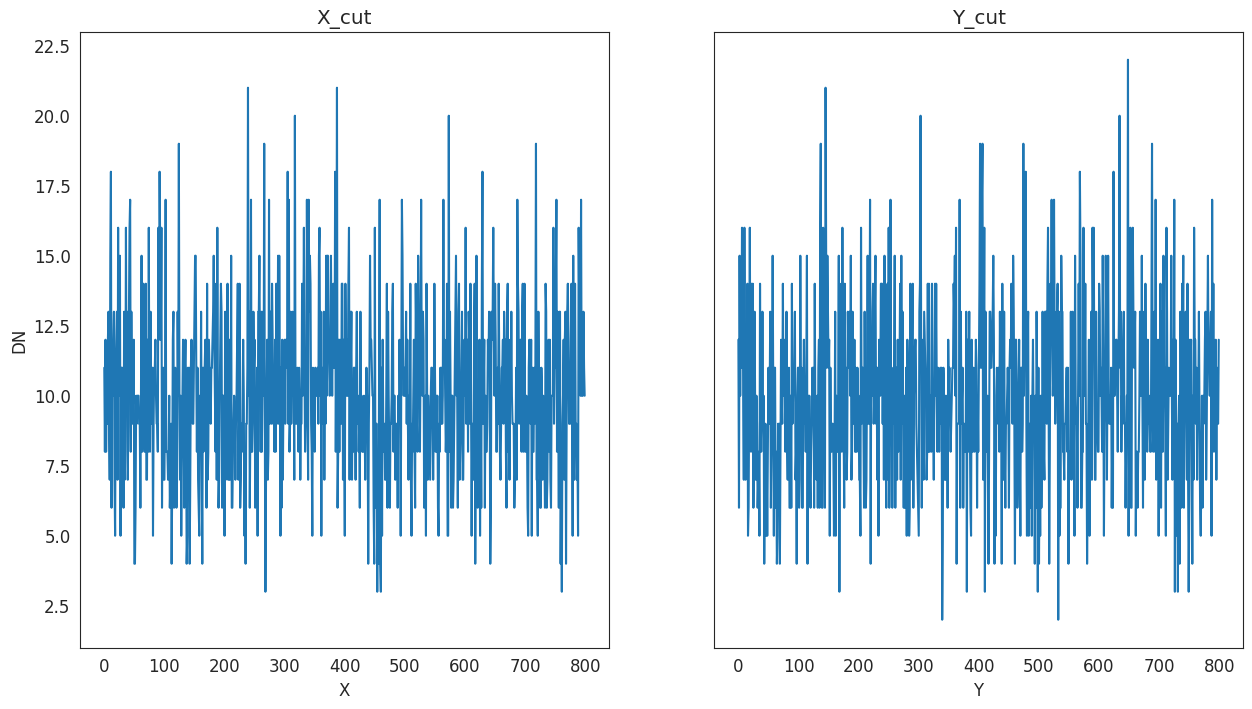

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (15,8), sharey = True)
ax[0].plot(sim.DNFP_array[:,500])
ax[0].set_title('X_cut')
ax[0].set_xlabel('X')
ax[0].set_ylabel('DN')
ax[1].plot(sim.DNFP_array[50,:])
ax[1].set_title('Y_cut')
ax[1].set_xlabel('Y')

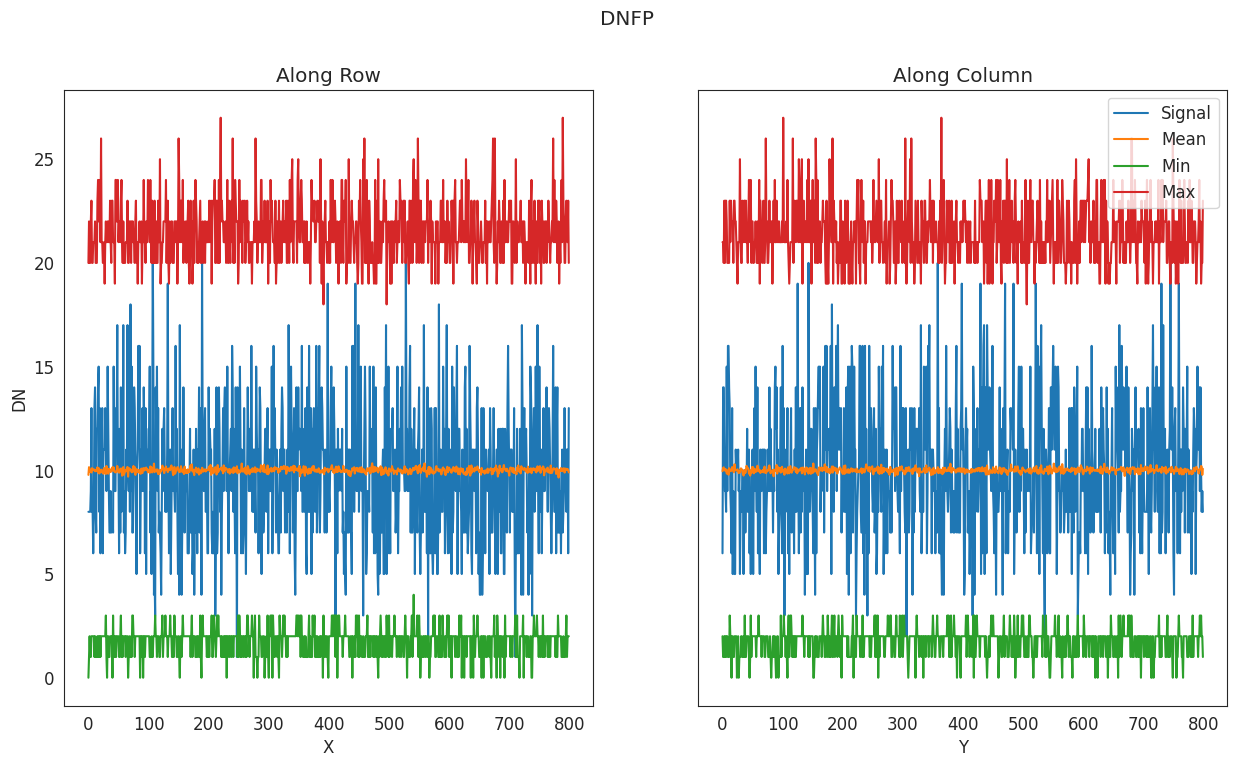

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (15,8), sharey = True)
ax[0].plot(sim.DNFP_array[:,392])
ax[0].plot(sim.DNFP_array.mean(axis = 0))
ax[0].plot(sim.DNFP_array.min(axis = 0))
ax[0].plot(sim.DNFP_array.max(axis = 0))
ax[0].set_title('Along Row')
ax[0].set_xlabel('X')
ax[0].set_ylabel('DN')
ax[1].plot(sim.DNFP_array[392,:])
ax[1].plot(sim.DNFP_array.mean(axis = 1))
ax[1].plot(sim.DNFP_array.min(axis = 1))
ax[1].plot(sim.DNFP_array.max(axis = 1))
ax[1].set_title('Along Column')
ax[1].set_xlabel('Y')
fig.suptitle('DNFP')
plt.legend(['Signal', 'Mean','Min','Max'])

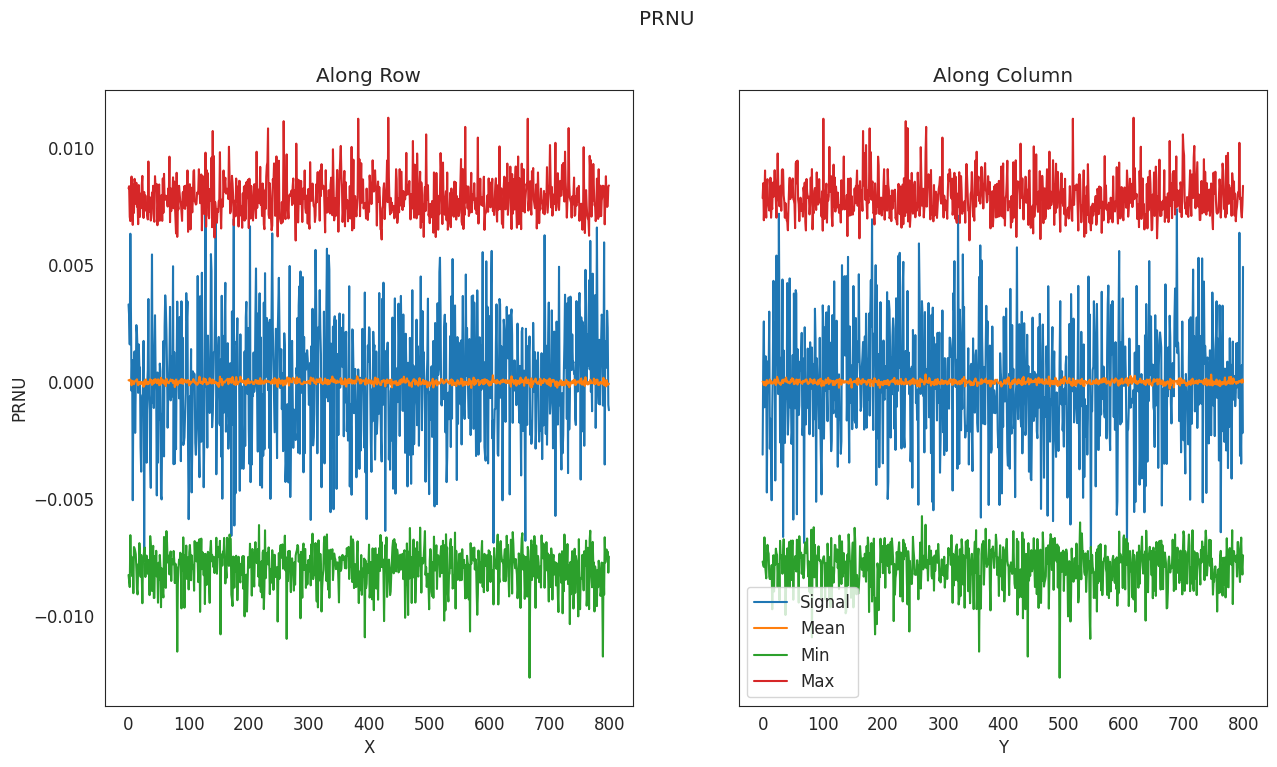

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (15,8), sharey = True)
ax[0].plot(sim.PRNU_array[:,392])
ax[0].plot(sim.PRNU_array.mean(axis = 0))
ax[0].plot(sim.PRNU_array.min(axis = 0))
ax[0].plot(sim.PRNU_array.max(axis = 0))
ax[0].set_title('Along Row')
ax[0].set_xlabel('X')
ax[0].set_ylabel('PRNU')
ax[1].plot(sim.PRNU_array[392,:])
ax[1].plot(sim.PRNU_array.mean(axis = 1))
ax[1].plot(sim.PRNU_array.min(axis = 1))
ax[1].plot(sim.PRNU_array.max(axis = 1))
ax[1].set_title('Along Column')
ax[1].set_xlabel('Y')
fig.suptitle('PRNU')
plt.legend(['Signal', 'Mean','Min','Max'])

### **Off axis Vs On Axis**

In [ ]:
tel_params_off ={
            'aperture'       : 100,
            'pixel_scale'    : 0.1,
            'psf_file'       : f'{data_path}/PSF/INSIST/off_axis_poppy.npy',
            'response_funcs' :  [ f'{data_path}/INSIST/UV/Filter.dat,1,100',
                                  f'{data_path}/INSIST/UV/Coating.dat,5,100',   # 5 mirrors
                                 f'{data_path}/INSIST/UV/Dichroic.dat,2,100',   # 2 dichroics
                                ],
            }

tel_params_on ={
            'aperture'       : 100,
            'pixel_scale'    : 0.1,
            'psf_file'       : f'{data_path}/PSF/INSIST/on_axis_poppy.npy',
            'response_funcs' :  [ f'{data_path}/INSIST/UV/Filter.dat,1,100',
                                  f'{data_path}/INSIST/UV/Coating.dat,6,100',   # 5 mirrors
                                  f'{data_path}/INSIST/UV/Dichroic.dat,2,100',   # 2 dichroics
                                ],
            'coeffs'          : 0.17
            }

In [ ]:
y,x = 2*np.mgrid[0:10,0:10]/3600

ra  = 10 + x.ravel()
dec = 10 + y.ravel()
mag = np.linspace(18, 30, 100)
df  = pd.DataFrame(zip(ra,dec,mag), columns = ['ra','dec','mag'])

In [ ]:
sim_off = pt.Imager(df = df,tel_params = tel_params_off, n_x = 200, n_y = 200,
                   exp_time = 2400)
sim_on = pt.Imager(df = df,tel_params = tel_params_on,   n_x = 200, n_y = 200,
                   exp_time = 2400)

In [ ]:
sim_off.W_eff, sim_off.lambda_phot

(998.3395060626349, 2340.0992814685787)

In [ ]:
sim_on.W_eff, sim_on.lambda_phot

(972.607878234245, 2355.377295882376)

In [ ]:
sim_off.zero_flux/sim_on.zero_flux

6.631061263264254

In [ ]:
det_params = {'shot_noise' :  'Poisson',
              'qe_response': [],
              'qe_mean'    :  1,
              'G1'         :  1,
              'bias'       :  10,
              'PRNU_frac'  :  0.25/100,
              'DCNU'       :  0.1/100,
              'RN'         :  3,
              'T'          :  218,
              'DN'         :  0.01/100
              }

In [ ]:
sim_off(det_params=det_params, detect_sources=False)
sim_on(det_params=det_params, detect_sources=False)

/usr/local/lib/python3.10/dist-packages/pista/analysis.py:178: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:178: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


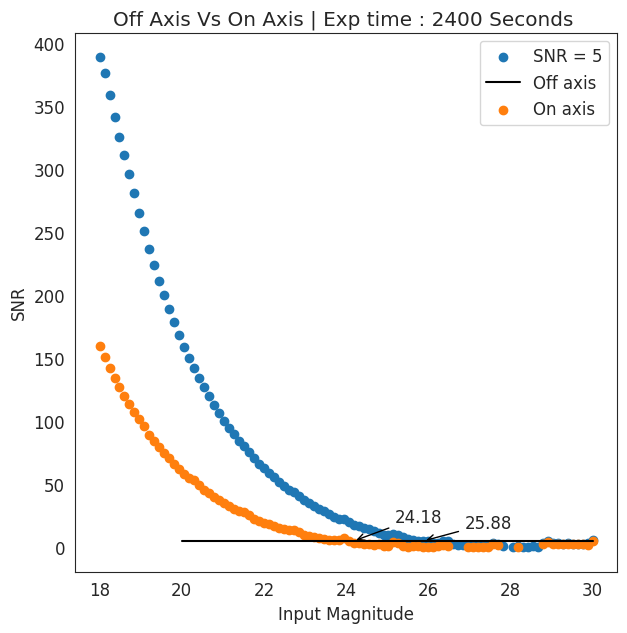

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (7,7))

data = sim_off.phot_table.to_pandas()
data = data.dropna()
x = data['mag_in']
y = data['SNR']

t = np.where(y<5)[0][0]
ax.scatter(x,y )

ax.plot([20,30],[5,5], color = 'black')
ax.set_title('Off Axis Vs On Axis | Exp time : 2400 Seconds ')

ax.annotate('{0:.2f}'.format(x[t]), (x[t],5), xytext = (x[t]+1,5+10),arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3", color = 'black'))

data = sim_on.phot_table.to_pandas()
data = data.dropna()
x = data['mag_in']
y = data['SNR']

t = np.where(y<5)[0][0]
ax.scatter(x,y)
ax.set_xlabel('Input Magnitude')
ax.set_ylabel('SNR')
ax.legend(['SNR = 5', 'Off axis', 'On axis'])
ax.annotate('{0:.2f}'.format(x[t]), (x[t],5), xytext = (x[t]+1,5+15),arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3", color = 'black'))

plt.subplots_adjust(wspace = 0.01)

### **INSIST vs UVIT vs GALEX**

In [ ]:
!git clone https://github.com/Jack3690/INSIST

Cloning into 'INSIST'...
remote: Enumerating objects: 5254, done.
remote: Counting objects: 100% (724/724), done.
remote: Compressing objects: 100% (398/398), done.
remote: Total 5254 (delta 482), reused 481 (delta 323), pack-reused 4530
Receiving objects: 100% (5254/5254), 1.14 GiB | 37.36 MiB/s, done.
Resolving deltas: 100% (3226/3226), done.


In [ ]:
data_git = '/content/INSIST/data'

In [ ]:
# Example using FITS table
tab = Table.read(f'{data_path}/sample.fits')  # FITS Table
df  = tab.to_pandas()             # PISTA requires pandas DataFrame

In [ ]:
tel_params_insist = {
            'aperture'       : 100,
            'pixel_scale'    : 0.1,
            'psf_file'       : f'{data_path}/PSF/INSIST/on_axis_hcipy.npy',
            'response_funcs' :  [ f'{data_path}/INSIST/UV/Filter.dat,1,100',
                                  f'{data_path}/INSIST/UV/Coating.dat,5,100',   # 5 mirrors
                                  f'{data_path}/INSIST/UV/Dichroic.dat,2,100',   # 2 dichroics
                                  f'{data_path}/INSIST/UV/QE.dat,1,100'
                                ],
            }
tel_params_uvit = {
            'aperture'       : 1,
            'pixel_scale'    : 3.33/8,
            'psf_file'       : f'{data_git}/UVIT/PSF/on_axis_hcipy.npy',
            'response_funcs' :  [ f'{data_git}/UVIT/filters/Astrosat_UVIT.F148W.dat,1,1'
                                ],
            'coeffs'         : 1/(np.pi*0.5**2)
            }

tel_params_galex = {
            'aperture'       : 1,
            'pixel_scale'    : 1.5,
            'psf_file'       : f'{data_git}/GALEX/PSF/PSFnuv_faint.fits',
            'response_funcs' :  [ f'{data_git}/GALEX/filters/GALEX_GALEX.NUV.dat,1,1'
                                ],
            'coeffs'         : 1/(np.pi*0.5**2)
                  }

In [ ]:
det_params_insist = {'shot_noise': 'Poisson',
                    'bias': 35,
                    'G1': 1,
                    'bit_res': 14,
                    'RN': 5,
                    'PRNU_frac': 0.0025,
                    'T': 218,
                    'DFM': 0.01424,
                    'pixel_area': 1e-06,
                    'DN': 0.001,
                    'NF': 12,
                    'FWC': 140000.0,
                    'C_ray_r': 0.04}

det_params_uvit  = {'shot_noise': 'Poisson',
                    'bias': 100,
                    'G1': 1,
                    'bit_res': 14,
                    'RN': 5,
                    'PRNU_frac': 0.0025,
                    'T': 293,
                    'DFM': 0.004624,
                    'pixel_area': (25/8)*1e-6,
                    'DN': 0.001,
                    'NF': 0,
                    'FWC': 150000.0}

det_params_galex = {'shot_noise': 'Poisson',
                    'bias': 35,
                    'G1': 1,
                    'bit_res': 14,
                    'RN': 5,
                    'PRNU_frac': 0.0025,
                    'T': 293,
                    'DFM': 0.01424,
                    'pixel_area': (25/8)*1e-06,
                    'DN': 0.001,
                    'NF': 0,
                    'FWC': 140000.0}

In [ ]:
sim_galex  = pt.Imager(df = df,coords = (11.06875, 41.3513),
                        tel_params = tel_params_galex, n_x = 27, n_y = 27,
                        exp_time = 2000)

sim_uvit   = pt.Imager(df = df, coords = (11.06875, 41.3513),
                      tel_params = tel_params_uvit, n_x = 96, n_y = 96,
                      exp_time = 2000)

sim_insist = pt.Imager(df = df, coords = (11.06875, 41.3513),
                      tel_params = tel_params_insist, n_x = 400, n_y = 400,
                      exp_time = 2000)

In [ ]:
sim_galex.DC = False
sim_galex(det_params = det_params_galex)
sim_uvit.DC = False
sim_uvit(det_params = det_params_uvit)

sim_insist(det_params = det_params_insist)

/usr/local/lib/python3.10/dist-packages/pista/analysis.py:178: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:178: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:178: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Text(0.5, 0.98, 'GALEX')

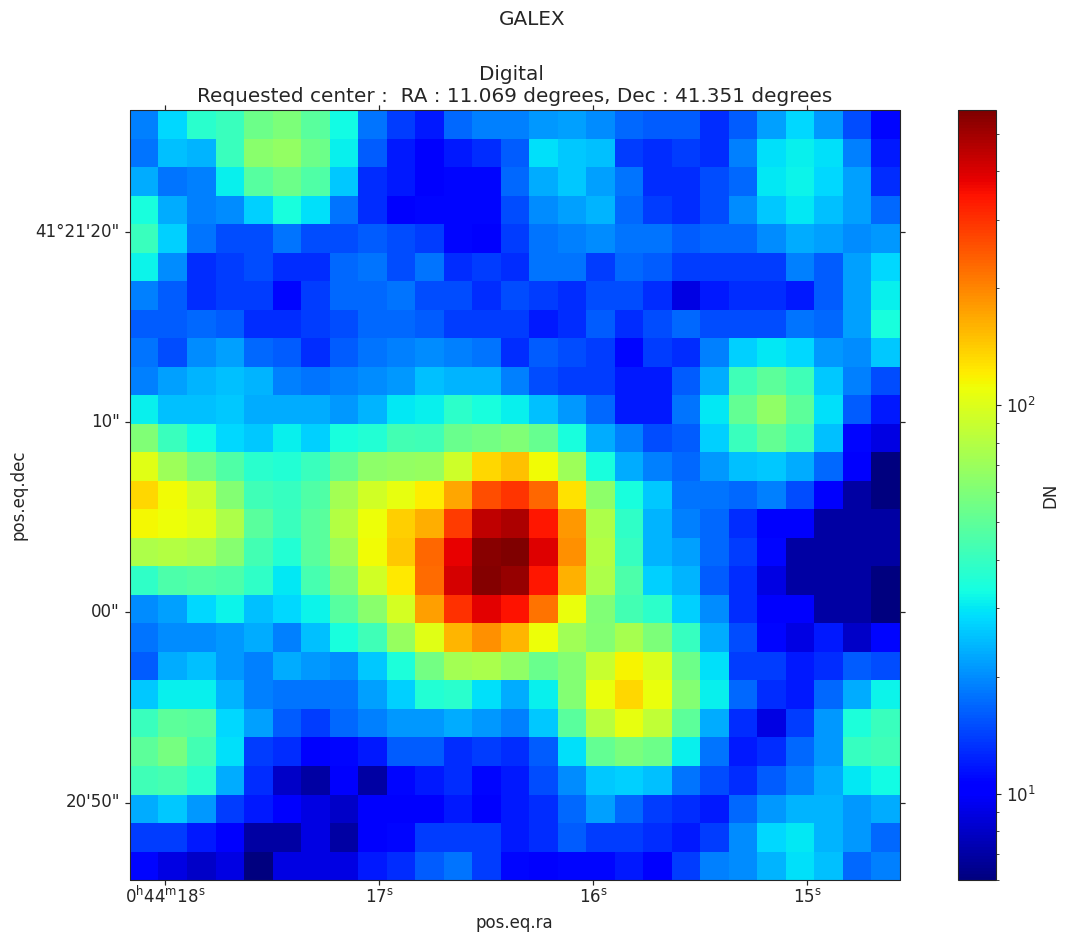

In [ ]:
fig,ax = sim_galex.show_image()
fig.suptitle('GALEX')

Text(0.5, 0.98, 'UVIT')

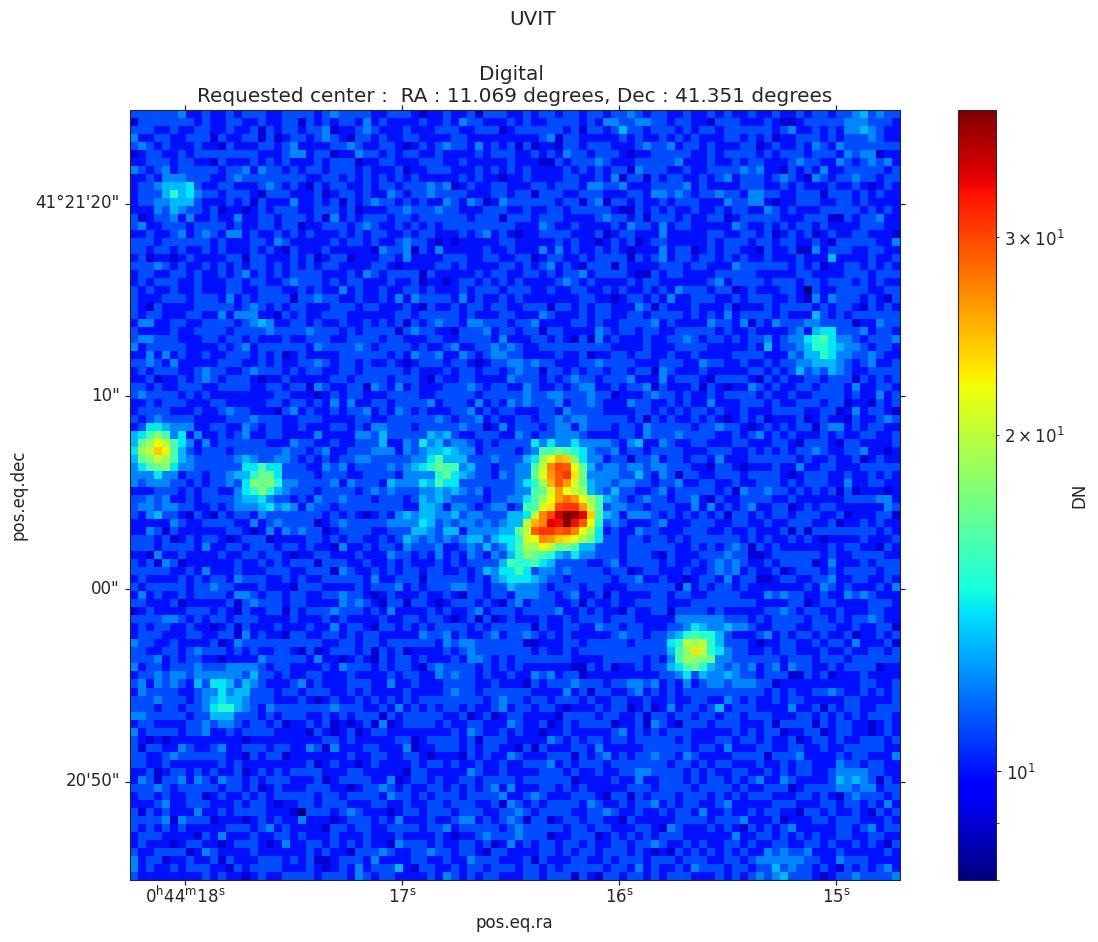

In [ ]:
fig, ax = sim_uvit.show_image()
fig.suptitle('UVIT')

Text(0.5, 0.98, 'INSIST')

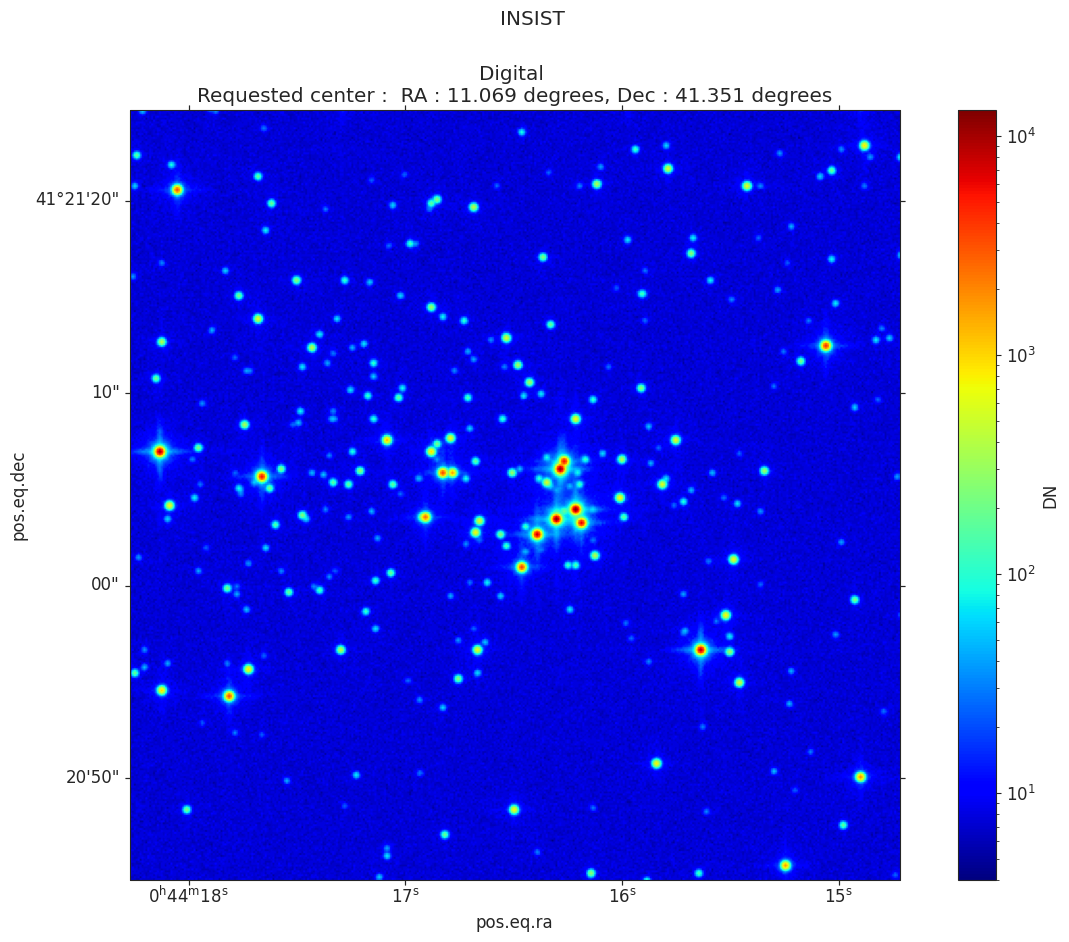

In [ ]:
fig, ax = sim_insist.show_image()
fig.suptitle('INSIST')

In [ ]:
sim_galex.writecomp('galex.fits'), sim_uvit.writecomp('uvit.fits'), sim_insist.writecomp('insist.fits')

(None, None, None)

In [ ]:
!zip comp galex.fits uvit.fits insist.fits

  adding: galex.fits (deflated 83%)
  adding: uvit.fits (deflated 69%)
  adding: insist.fits (deflated 17%)


# **ArtPop**

Combining ArtPop and PISTA

In [ ]:
!pip install artpop --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 6.8 MB/s eta 0:00:00


In [ ]:
import artpop as art

/root/.artpop/mist. To change this location, create a MIST_PATH environment variable.


In [ ]:
art.phot_system_list

['HST_WFC3',
 'HST_ACSWF',
 'SDSSugriz',
 'CFHTugriz',
 'DECam',
 'HSC',
 'JWST',
 'LSST',
 'UBVRIplus',
 'UKIDSS',
 'WFIRST',
 'GALEX']

In [ ]:
rng = np.random.RandomState(369)

In [ ]:
src = art.MISTSersicSSP(
    log_age = 6,        # log of age in years
    feh = -2.5,           # metallicity [Fe/H]
    r_eff = 250 * u.pc,   # effective radius
    n = 0.8,              # Sersic index
    theta = 135 * u.deg,  # position angle
    ellip = 0.3,          # ellipticity
    num_stars = 1e6,      # number of stars
    phot_system = 'GALEX', # photometric system
    distance = 5 * u.Mpc, # distance to system
    xy_dim = 801,         # image dimension
    pixel_scale = 0.1,    # pixel scale in arcsec / pixel
    random_state = rng,   # random state for reproducibility
)

INFO:ArtPop Logger:Fetching MIST synthetic photometry grid for GALEX.


INFO: Fetching MIST synthetic photometry grid for GALEX.


INFO:ArtPop Logger:Extracting grid from MIST_v1.2_vvcrit0.4_GALEX.txz.


INFO: Extracting grid from MIST_v1.2_vvcrit0.4_GALEX.txz.


In [ ]:
imager = art.ArtImager(
    phot_system  = 'GALEX', # photometric system
    diameter     =  1*u.m, # effective aperture diameter
    read_noise   = 3,       # read noise in electrons
    random_state = rng    # random state for reproducibility
)

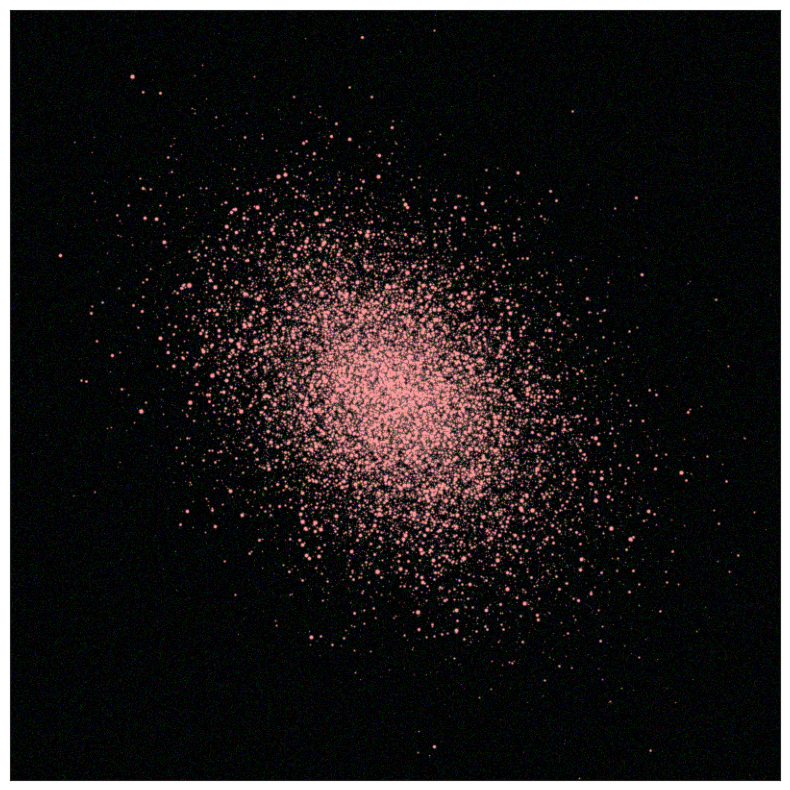

In [ ]:
psf = art.moffat_psf(fwhm=0.2*u.arcsec)

# observe in gri (assuming the same seeing in all bands)
obs_g = imager.observe(
    source = src,         # source object
    bandpass = 'GALEX_NUV',  # bandpass of observation
    exptime = 10 * u.min, # exposure time
    sky_sb = 27,          # sky surface brightness
    psf = psf             # point spread function
)
obs_r = imager.observe(src, 'GALEX_NUV', 10 * u.min, sky_sb=27, psf=psf)
obs_i = imager.observe(src, 'GALEX_FUV', 30 * u.min, sky_sb=27, psf=psf)

rgb = make_lupton_rgb(obs_i.image, obs_r.image, obs_g.image, stretch=0.4)

art.show_image(rgb);

In [ ]:
df = pd.DataFrame(zip(src.x, src.y), columns =['x', 'y'])

In [ ]:
df['mag'] = src.mags['GALEX_NUV']

In [ ]:
tel_params ={
            'aperture'       : 100,
            'pixel_scale'    : 0.1,
            'psf_file'       : f'{data_path}/PSF/INSIST/on_axis_hcipy.npy',
            'response_funcs' :  [ f'{data_path}/INSIST/UV/Filter.dat,1,100',
                                  f'{data_path}/INSIST/UV/Coating.dat,5,100',   # 5 mirrors
                                  f'{data_path}/INSIST/UV/Dichroic.dat,2,100',   # 2 dichroics
                                ],
            }

In [ ]:
sim = pt.Imager(df = df,tel_params = tel_params, n_x = 801, n_y = 801,
                   exp_time = 1800)

Converting xy to ra-dec


(<Figure size 1000x1000 with 2 Axes>,
 <Axes: title={'center': 'Requested Center :  RA : 10.0 degrees, Dec : 10.0 degrees 999554 sources\n                            Fov(RA) : 0.0223 (deg) | Fov(Dec) : 0.0223 (deg)'}, xlabel='RA (Degrees)', ylabel='Dec (Degrees)'>)

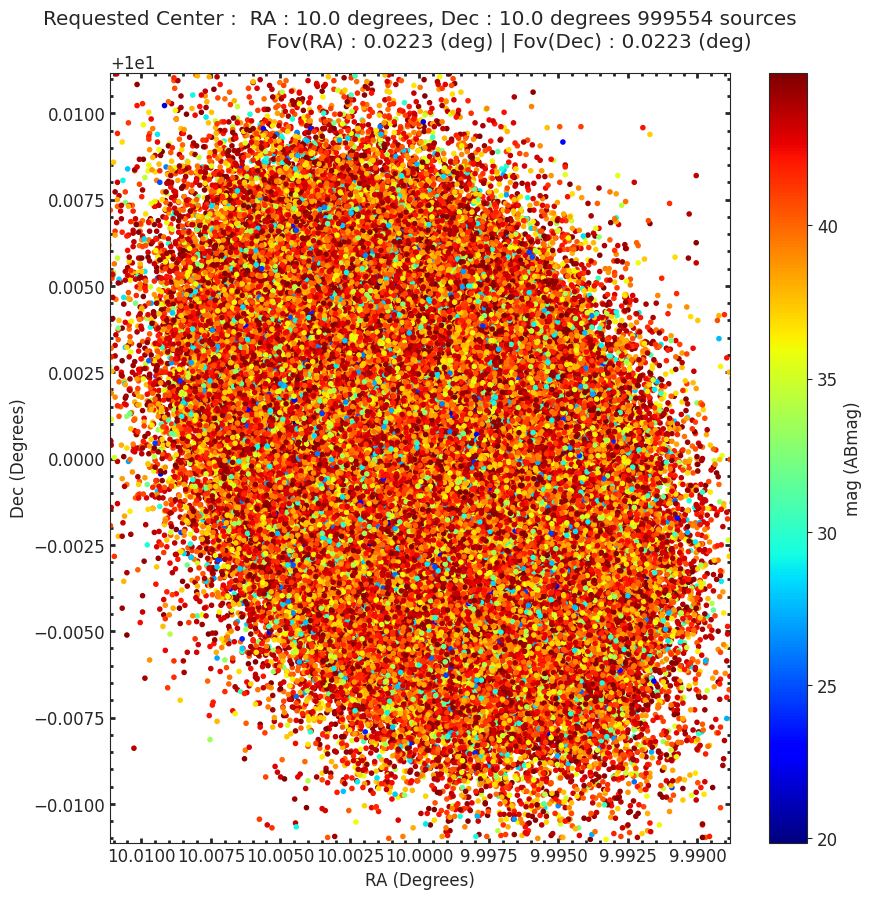

In [ ]:
sim.show_field()

In [ ]:
det_params = {    'shot_noise' :  'Gaussian',
                  'G1'         :  1,
                  'PRNU_frac'  :  0.25/100,
                  'RN'         :  5,
                  'T'          :  218,
                  'DN'         :  0.1/100
                     }

In [ ]:
sim(det_params = det_params, photometry = None)

(<Figure size 1080x720 with 2 Axes>,
 <matplotlib.axes._subplots.WCSAxesSubplot at 0x7f79375bde50>)

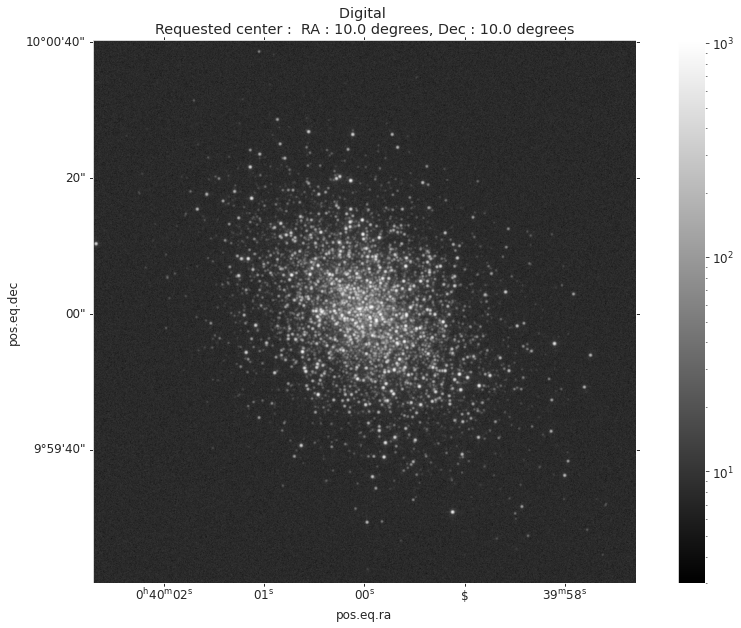

In [ ]:
sim.show_image(cmap = 'gray') # Displays the final simulated digital image

# **Galaxy**


## **Using GalSim**

## **Resolved Galaxy Simulation**